## <center> Diabetes Prediction using Decision Tree Algorithm <center/>

In [1]:
# Modify display settings

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
np.random.seed(4)

In [3]:
# Read the data from the file and render it

dataset = pd.read_csv('Diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### <center> Data preprocessing </center>

In [4]:
# Count number of instances of each class to check if the dataset is balanced

unique = dataset["Outcome"].unique()
print("Unique labels:", unique)
label_names = ["True", "False"]
print("Labels names:", label_names)

feature_names = dataset.iloc[:, : -1].columns.tolist()
print("Feature names:", feature_names)

positive_class_number = dataset[dataset.Outcome == unique[0]].shape[0]
negative_class_number = dataset[dataset.Outcome == unique[1]].shape[0]
print("Number of instances with positive labeles:", positive_class_number)
print("Number of instances with negative labeles:", negative_class_number)

Unique labels: [1 0]
Labels names: ['True', 'False']
Feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'PedigreeFunction', 'Age']
Number of instances with positive labeles: 268
Number of instances with negative labeles: 500


In [5]:
# Use oversampling for addressing imbalanced dataset issue

positive_class_dataset = dataset[dataset.Outcome == unique[0]]
negative_class_dataset = dataset[dataset.Outcome == unique[1]]

positive_class_oversample = positive_class_dataset.sample(negative_class_number, replace = True)

print("Number of instances with positive labeles after oversampling:", positive_class_oversample.shape[0])

dataset = pd.concat((positive_class_oversample, negative_class_dataset), axis = 0)
print("Dataset shape after oversampling:", dataset.shape)

Number of instances with positive labeles after oversampling: 500
Dataset shape after oversampling: (1000, 9)


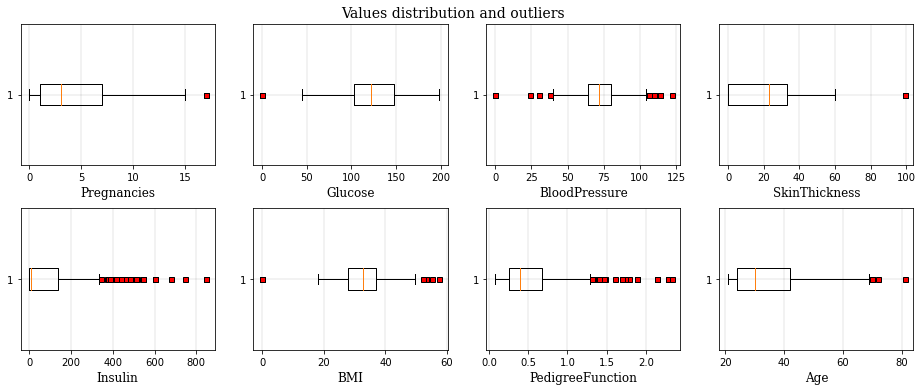

In [6]:
# Represent the parameters graphically to get insight into it

k = 2  # Number of graphs in a column
f = 4  # Number of graphs in a row
figure, axes = plt.subplots(k, f)
figure.set_figheight(6)
figure.set_figwidth(16)
figure.subplots_adjust(wspace = 0.2, hspace = 0.3)  # Set horizontal and vertical spaces between the sublots
figure.suptitle("Values distribution and outliers", fontsize = 14, fontfamily = "serif", y = 0.92)

m = 0  # Number of the graph
for i in range(0, k):
    for j in range(0, f):
        outliersprop = dict(markerfacecolor = 'red', marker = 's', markersize = 5)        
        axes[i, j].boxplot(dataset.iloc[:, m], vert=False, showfliers=True, flierprops = outliersprop)
        axes[i, j].set_xlabel(dataset.columns[m], fontsize = 12, fontfamily = "serif")
        axes[i, j].grid(color='black', linewidth=0.1)
        m += 1

In [7]:
# Transform the data into numpy arrays

X = np.array((dataset.iloc[:, :-1]))
Y = np.reshape(np.array((dataset.iloc[:, -1])), (-1, 1))

print("Shape of the training set: {}" .format(X.shape))
print("Shape of the labels: {}" .format(Y.shape))

Shape of the training set: (1000, 8)
Shape of the labels: (1000, 1)


In [8]:
# Split dataset into training and test set

from sklearn.model_selection import train_test_split

# Relegate 20% of the instances to the test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 15, stratify = Y)

training_set = np.concatenate((X_train, Y_train), axis = 1)
testing_set = np.concatenate((X_test, Y_test), axis = 1)

print('Training set shape: {}' .format(training_set.shape))
print('Test set shape: {}' .format(testing_set.shape))

Training set shape: (800, 9)
Test set shape: (200, 9)






### <center> Decision tree implementation in plain python </center>

The problem of binary classification is solved using decision tree algorithm, which is implemented by recursive inception of nodes or leaves in case of dataset purity. In addition, since the dataset has outliers, the risk of overfitting is reduced by using maximum tree depth threshold. 

In [9]:
# Create a node of the tree which consists of the question for split, true branch and false branch

class Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [10]:
# Create a leaf, which contains slassified samples

class Leaf:
    def __init__(self, subset):
        self.predicted_labels = max(counts(subset), key = lambda x: counts(subset)[x])

In [11]:
# Create a question, which is defined by number of feature column and feature value

class Question:
    def __init__(self, question_number, question_value):
        self.question_number = question_number
        self.question_value = question_value
        
    def match(self, sample_values):
        if isinstance(self.question_value, int) or isinstance(self.question_value, float):
            return sample_values[self.question_number] >= self.question_value
        else:
            return sample_values[self.question_number] == self.question_value

In [12]:
# Calculate number of samples related to each class

def counts(split):
    counts = {}
    for i in range(0, split.shape[0]):
        label = split[i, -1]
        counts[label] = counts.get(label, 0) + 1
    return counts

Use gini impurity as a criteria for best split determination, it is calculated as follows:
$$ Gini = \sum \limits _{l = 1} ^{n_{classes}} {p_{c} \cdot (1 - p_{c})} $$

Probality of a sample belonging to a certain class:
$$ p_{c} = \frac {N_{class}} {N_{total}} $$


In [13]:
# Calculate impurity of the split

def gini_impurity(split):
    gini = 0
    count = counts(split)
    for c in count:
        gini += ((count[c] / split.shape[0]) * (1 - (count[c] / split.shape[0])))
    return gini

In [14]:
# Calculate quality of the partition

def split_quality(true_split, false_split, parent_split_quality):
    
    n_true = true_split.shape[0]
    n_false = false_split.shape[0]
    
    total_number = n_true + n_false 
    quality = parent_split_quality - (gini_impurity(true_split) * (n_true / total_number) 
              + gini_impurity(false_split) * (n_false / total_number))
    return quality

In [15]:
# Divide the dataset into true and false subsets

def split(question_candidate, training_set):
    m = training_set.shape[0]  # Number of training samples
    
    true_subset = []
    false_subset = []
    
    for i in range(0, m):  # For each sample check if the feature matches the question
        if question_candidate.match(training_set[i, :]): 
            true_subset.append(training_set[i, :])
        else:
            false_subset.append(training_set[i, :])                 
    return np.array(true_subset), np.array(false_subset)  # Return the subsets as numpy arrays

In [16]:
# Determine the best question to split the data into true and false subsets

def determine_split(training_set):
    m = training_set.shape[0]  # Number of training samples
    n = training_set.shape[1] - 1  # Number of features
    
    parent_split_quality = gini_impurity(training_set)  # Calculate information gain for the parent dataset
    best_split_quality = 0 
    best_question = None
    
    for j in range(0, n):  # Assume each value of the features is a question candidate and calculate its information gain
        features = list(set(training_set[:, j]))
        for item in features:
            question_candidate = Question(j, item)
            true_subset, false_subset = split(question_candidate, training_set)
            current_split_quality = split_quality(true_subset, false_subset, parent_split_quality)

            if current_split_quality > best_split_quality:  # Find the question with the largest information gain
                best_split_quality = current_split_quality
                best_question = question_candidate
    return best_question, best_split_quality

In [17]:
# Create a recursive function, which builds decision tree 

def decision_tree(training_set, counter, max_depth):
    
    question, quality = determine_split(training_set)
    
    # If every sample belongs to the same class, create a leaf
    if quality == 0 or counter == max_depth:
        return Leaf(training_set)
    
    counter +=1
    
    true_subset, false_subset = split(question, training_set)

    true_branch = decision_tree(true_subset, counter, max_depth)
    false_branch = decision_tree(false_subset, counter, max_depth)
    
    return Node(question, true_branch, false_branch)

In [18]:
# Create a decision tree

counter = 0
max_depth = 10
decision_tree = decision_tree(training_set, counter, max_depth)

In [19]:
# Create a function for predictions

def classify(row, node):

    if isinstance(node, Leaf):
        return node.predicted_labels

    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [20]:
# Create a function for accuracy calculation

def tree_accuracy(dataset, decision_tree):
    accuracy = 0
    for i in range(dataset.shape[0]):
        label = dataset[i, -1] 
        if label == classify(dataset[i, :], decision_tree):
            accuracy += 1
    accuracy = accuracy / dataset.shape[0]
    return accuracy

In [21]:
# Evaluate model performance

training_accuracy = tree_accuracy(training_set, decision_tree)
print("Training accuracy: {}%".format(round(training_accuracy * 100, 1)))

testing_accuracy = tree_accuracy(testing_set, decision_tree)
print("Testing accuracy: {}%\n\n\n".format(round(testing_accuracy * 100, 1)))

Training accuracy: 97.6%
Testing accuracy: 87.5%





### <center> Decision tree implementation using scikit-learn </center>

In [22]:
# Import required scikit-learn modules

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Implement decision tree using scikit-learn

model = DecisionTreeClassifier(criterion = "gini", max_depth = 10)
model = model.fit(X_train, Y_train)

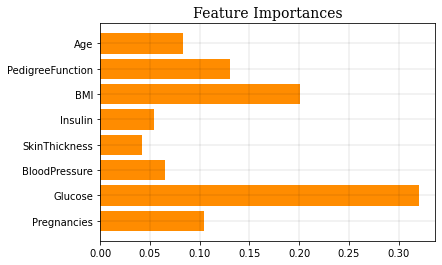

In [23]:
# Identify the features, which have the maximum influence on the outcome

importance = model.feature_importances_

importance_plt = plt.barh(list(dataset.columns[: -1]), importance, color = "darkorange")
importance_plt = plt.title("Feature Importances", fontsize = 14, fontfamily = "serif")
importance_plt = plt.grid(color='black', linewidth=0.1)

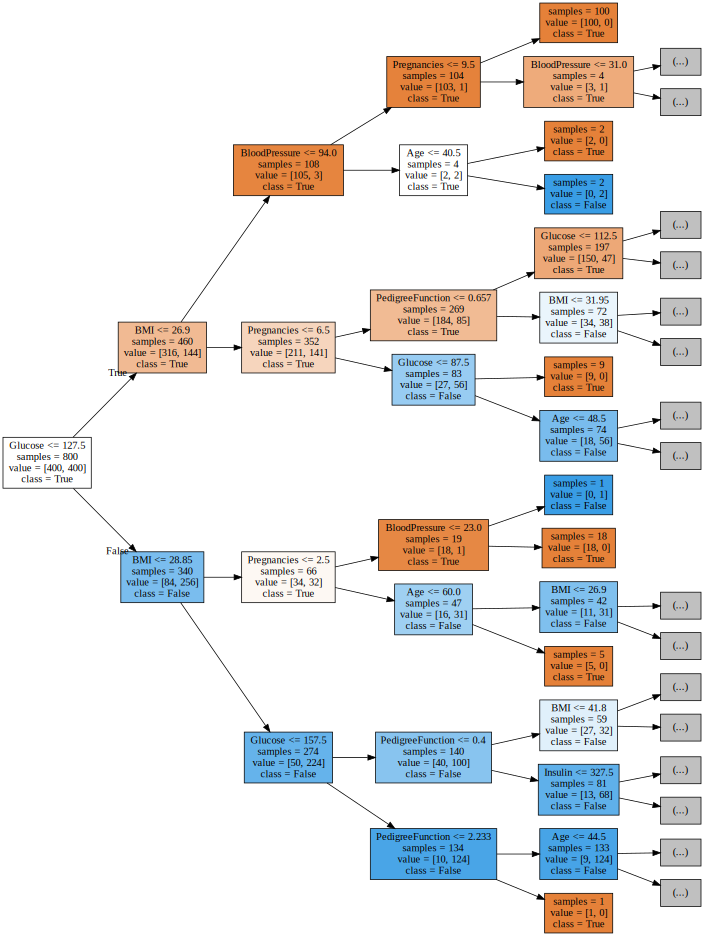

In [24]:
# Display decision tree graphically using graphviz module

import pydotplus
import graphviz 

tree_scheme = tree.export_graphviz(model, feature_names = feature_names, class_names = label_names,
              filled = True, max_depth = 4, rotate = True, impurity = False)  

pydot_graph = pydotplus.graph_from_dot_data(tree_scheme)
pydot_graph.set_size('"13!"')
graph = graphviz.Source(pydot_graph.to_string())
graph

Precision is an accuracy of one class predictions: 
$$ precision = \frac {TP} {TP + FP} $$
Recall is a ratio of one class instances that are correctly detected by the classifier:
$$ recall = \frac {TP} {TP + FN} $$

F<sub>1</sub> score is a harmonic mean of precision and recall:
$$ F_{1} = 2 \cdot \frac {precision \cdot recall} {precision + recall} $$

In [25]:
# Evaluate training model performance

prediction = model.predict(X_train)
accuracy_training = accuracy_score(Y_train, prediction)
print("Training accuracy: {}%".format(round(accuracy_training * 100, 1)))

# Calculate confusion matrix, it has the form [[true_negatives, false_negatives], [[false_positives, true_positives]]]
confusion_matrix_training = confusion_matrix(Y_train, prediction)
print("True negatives:", confusion_matrix_training[0][0])
print("False negatives:", confusion_matrix_training[0][1])
print("False positives:", confusion_matrix_training[1][0])
print("True positives:", confusion_matrix_training[1][1])

# Calculate F1 score, a harmonic mean of precision and recall
f1 = f1_score(Y_train, prediction)
print("Training F1 score: {}%".format(round(f1 * 100, 1)))

Training accuracy: 97.6%
True negatives: 391
False negatives: 9
False positives: 10
True positives: 390
Training F1 score: 97.6%


In [26]:
# Evaluate test performance

prediction = model.predict(X_test)
accuracy_test = accuracy_score(Y_test, prediction)
print("Test accuracy: {}%".format(round(accuracy_test * 100, 1)))

confusion_matrix_test = confusion_matrix(Y_test, prediction)
print("True negatives:", confusion_matrix_test[0][0])
print("False negatives:", confusion_matrix_test[0][1])
print("False positives:", confusion_matrix_test[1][0])
print("True positives:", confusion_matrix_test[1][1])

f1 = f1_score(Y_test, prediction)
print("Test F1 score: {}%".format(round(f1 * 100, 1)))

Test accuracy: 87.5%
True negatives: 84
False negatives: 16
False positives: 9
True positives: 91
Test F1 score: 87.9%
